<img src="http://drive.google.com/uc?export=view&id=1tpOCamr9aWz817atPnyXus8w5gJ3mIts" width=500px>

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

### Package Version:
- tensorflow==2.2.0
- pandas==1.0.5
- numpy==1.18.5
- google==2.0.3

# Sarcasm Detection

### Dataset

#### Acknowledgement
Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

### Load Data (3 Marks)

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Setting the current working directory
import os; os.chdir('drive/My Drive/dataset/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import packages
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline



# Models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# Set random state
random_s = 42
np.random.seed(random_s)
tf.random.set_seed(random_s)

In [ ]:
data = pd.read_json('./Sarcasm_Headlines_Dataset.json', lines = True)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data.head())

Data has 26709 rows and 3 columns. Here are the first five rows of the data...


article_link  ... is_sarcastic
0  https://www.huffingtonpost.com/entry/versace-b...  ...            0
1  https://www.huffingtonpost.com/entry/roseanne-...  ...            0
2  https://local.theonion.com/mom-starting-to-fea...  ...            1
3  https://politics.theonion.com/boehner-just-wan...  ...            1
4  https://www.huffingtonpost.com/entry/jk-rowlin...  ...            0

[5 rows x 3 columns]

------------------------------------------------------------
Value Counts for `is_sarcastic` label
------------------------------------------------------------
Is Sarcastic count: 11724 i.e. 44.0%
Isn't Sarcastic count: 14985 i.e. 56.0%
------------------------------------------------------------
Distributon of `is_sarcastic` label
------------------------------------------------------------


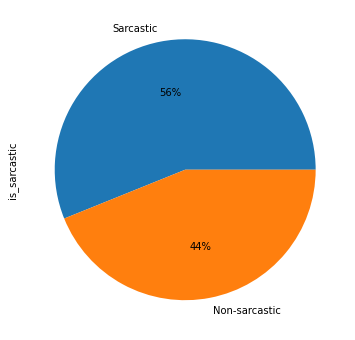

In [ ]:
print('--'*30); print('Value Counts for `is_sarcastic` label'); print('--'*30)
print(f'Is Sarcastic count: {data[data.is_sarcastic == 1].shape[0]} i.e. {round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 0)}%')
print(f'Isn\'t Sarcastic count: {data[data.is_sarcastic == 0].shape[0]} i.e. {round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 0)}%')

print('--'*30); print('Distributon of `is_sarcastic` label'); print('--'*30)
_ = data['is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

In [ ]:
print('Analysis of `is_sarcastic` label by news website'); print('--'*30)

hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]], 
                     columns = ['huffingtonpost', 'theonion'], index = ['Sarcastic', 'Non-sarcastic']))

Analysis of `is_sarcastic` label by news website
------------------------------------------------------------


huffingtonpost  theonion
Sarcastic                   0     11724
Non-sarcastic           14985         1

In [ ]:
#Checking 5 random headlines and labels from the data
print('--'*30); print('Checking 5 random headlines and labels from the data'); print('--'*30)
rands = random.sample(range(1, data.shape[0]), 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

------------------------------------------------------------
Checking 5 random headlines and labels from the data
------------------------------------------------------------
Headline: mitch mcconnell inflates throat pouch in show of dominance over fellow congressional males
label: 1

Headline: news website refers to users' ceaseless exchange of racial slurs as 'discussion'
label: 1

Headline: gop ignores key lesson on race
label: 0

Headline: prince george and princess charlotte steal the show at pippa middleton's wedding
label: 0

Headline: exclusive video: sean hayes discovers family's criminal past
label: 0



------------------------------------------------------------
Checking 5 random headlines and labels from the data where the length of headline is > 100
------------------------------------------------------------
Headline: friday's morning email: inside the sexual harassment allegations against movie mogul harvey weinstein
label: 0

Headline: running in tap shoes: choreographer janine molinari on teaching broadway kids and other adventures in dance
label: 0

Headline: tearful mitt romney announces he has rare disease where you can't sit quietly on stool when repeatedly asked to
label: 1

Headline: republicans praise nixon administration for allowing qaddafi to rule libya so he could one day be overthrown
label: 1

Headline: nation's ever so malleable simpletons fluttering between candidates like shuttlecocks through every moment of debate
label: 1

------------------------------------------------------------
Distributon of label where the length of headline is > 100
-------------------

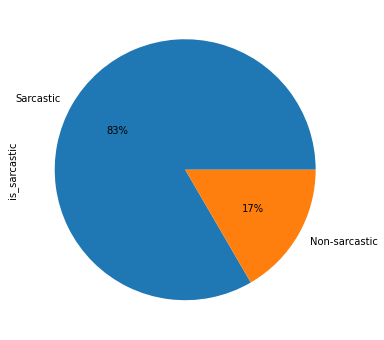

In [ ]:
# Checking 5 random headlines and labels from the data where the length of headline is > 100
print('--'*30); print('Checking 5 random headlines and labels from the data where the length of headline is > 100'); print('--'*30)
indexes = list(data.loc[data['headline'].str.len() > 100, 'headline'].index)
rands = random.sample(indexes, 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

print('--'*30); print('Distributon of label where the length of headline is > 100'); print('--'*30)
_ = data.loc[indexes, 'is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

Observation
44% of the data have sarcastic labels whereas 56% don't.
Suprising! There are no headlines from HuffPost that are sarcastic whereas all but one from The Onion are sarcastic.
Based on some random headlines seen above, it appears that the data is mostly lower-cased. Pre-processing such as removing punctuations and lemmatization can be used.
There are digits in the headlines for e.g. 3 things i needed to hear when i weighed 300 pounds where removing the digits wouldn't help.
83% of data where length of sentence (headlines) > 100 are sarcastic headlines.

There is an imbalance in data, there are more non sarcastic than sarcastic. MAybe that can skew the model? We may need to make it equal

In [ ]:
sarcastic_headlines = data.loc[data['is_sarcastic']==1]
#undersample non sarcastic headlines
non_sarcastic_headlines = data.loc[data['is_sarcastic']==0].sample(n=11724,random_state=10)

In [ ]:
sarcastic_headlines.count()

article_link    11724
headline        11724
is_sarcastic    11724
dtype: int64

In [ ]:
balanced_headlines=pd.concat([sarcastic_headlines, non_sarcastic_headlines])

In [ ]:
balanced_headlines['is_sarcastic'].value_counts()

1    11724
0    11724
Name: is_sarcastic, dtype: int64

### Drop `article_link` from dataset (3 Marks)

In [ ]:
print('Dropping `article_link` from the data'); print('--'*30)
data.drop('article_link', axis = 1, inplace = True)
balanced_headlines.drop('article_link', axis=1, inplace=True)

Dropping `article_link` from the data
------------------------------------------------------------


Data Preprocessing
Few of the data pre-processing steps taken before applying model on the data

Converting to lower case, avoid any capital cases
Converting apostrophe to the standard lexicons
Removing punctuations
Lemmatization

In [ ]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
def clean_text(text, remove_stopwords=True):
  # Convert words to lower case
  text = text.lower()
  if True:
    text = text.split()
    new_text = []
    for word in text:
      if word in contractions:
        new_text.append(contractions[word])
      else:
        new_text.append(word)
      text = " ".join(new_text)
      text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
      text = re.sub(r'\<a href', ' ', text)
      text = re.sub(r'&amp;', '', text)
      text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
      text = re.sub(r'<br />', ' ', text)
      text = re.sub(r'\'', ' ', text)
      if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
  return text

In [ ]:
# Clean the headlines
import re
from nltk.corpus import stopwords 
from pickle import dump, load

clean_balanced_headlines = []
for headline in balanced_headlines['headline']:
  clean_balanced_headlines.append(clean_text(headline, remove_stopwords=False))
print("balanced headlines are cleaned.")

balanced headlines are cleaned.


In [ ]:
balanced_headlines['cleaned_headline']=clean_balanced_headlines

In [ ]:
balanced_headlines.head()

headline  ...                                   cleaned_headline
2   mom starting to fear son's web series closest ...  ...  mom starting to fear son s web series closest ...
3   boehner just wants wife to listen, not come up...  ...  boehner just wants wife to listen  not come up...
8   top snake handler leaves sinking huckabee camp...  ...  top snake handler leaves sinking huckabee camp...
15  nuclear bomb detonates during rehearsal for 's...  ...  nuclear bomb detonates during rehearsal for  s...
16  cosby lawyer asks why accusers didn't come for...  ...  cosby lawyer asks why accusers did not come fo...

[5 rows x 3 columns]

In [ ]:
balanced_headlines.drop('headline', axis=1, inplace=True)

In [ ]:
balanced_headlines.head()

is_sarcastic                                   cleaned_headline
2              1  mom starting to fear son s web series closest ...
3              1  boehner just wants wife to listen  not come up...
8              1  top snake handler leaves sinking huckabee camp...
15             1  nuclear bomb detonates during rehearsal for  s...
16             1  cosby lawyer asks why accusers did not come fo...

### Get length of each headline and add a column for that (3 Marks)

In [ ]:
print (balanced_headlines['cleaned_headline'][2])

mom starting to fear son s web series closest thing she will have to grandchild


In [ ]:
print('--'*40); print('Get the length of each line, find the maximum length and print the maximum length line'); 
print('Length of line ranges from 7 to 241.'); print('--'*40)
# Get length of each line
balanced_headlines['line_length'] = balanced_headlines['cleaned_headline'].str.len()

print('Minimum line length: {}'.format(balanced_headlines['line_length'].min()))
print('Maximum line length: {}'.format(balanced_headlines['line_length'].max()))
print('Line with maximum length: {}'.format(balanced_headlines[balanced_headlines['line_length'] == balanced_headlines['line_length'].max()]['cleaned_headline'].values[0]))

--------------------------------------------------------------------------------
Get the length of each line, find the maximum length and print the maximum length line
Length of line ranges from 7 to 241.
--------------------------------------------------------------------------------
Minimum line length: 7
Maximum line length: 254
Line with maximum length: maya angelou  poet  author  civil rights activist  and—holy cow—tony award–nominated actress  college professor  magazine editor  streetcar conductor—really  streetcar conductor  wow—calypso singer  nightclub performer  and foreign journalist  dead at 86


In [ ]:
balanced_headlines.head(2)

is_sarcastic                                   cleaned_headline  line_length
2             1  mom starting to fear son s web series closest ...           79
3             1  boehner just wants wife to listen  not come up...           84

### Initialize parameter values
- Set values for max_features, maxlen, & embedding_size
- max_features: Number of words to take from tokenizer(most frequent words)
- maxlen: Maximum length of each sentence to be limited to 25
- embedding_size: size of embedding vector

In [ ]:
max_features = 10000
maxlen = 25
embedding_size = 200

### Apply `tensorflow.keras` Tokenizer and get indices for words (3 Marks)
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence


In [ ]:
num_words=max_features
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(balanced_headlines['cleaned_headline'])

### Pad sequences (3 Marks)
- Pad each example with a maximum length
- Convert target column into numpy array

In [ ]:
X = tokenizer.texts_to_sequences(balanced_headlines['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(balanced_headlines['is_sarcastic'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 23448
[   0    0    0    0    0    0    0    0    0    0  120  766    1  823
  231    4 2203  657 4289  212   72   33   40    1 9650]
Number of Labels:  23448
1


### Vocab mapping
- There is no word for 0th index

In [ ]:
print(tokenizer.word_counts)
print(tokenizer.document_count)
print(tokenizer.word_index)
print(tokenizer.word_docs)

OrderedDict([('mom', 200), ('starting', 43), ('to', 7351), ('fear', 41), ('son', 119), ('s', 3962), ('web', 16), ('series', 49), ('closest', 7), ('thing', 129), ('she', 312), ('will', 662), ('have', 504), ('grandchild', 2), ('boehner', 24), ('just', 528), ('wants', 113), ('wife', 86), ('listen', 19), ('not', 1389), ('come', 93), ('up', 758), ('with', 1601), ('alternative', 12), ('debt', 25), ('reduction', 3), ('ideas', 34), ('top', 106), ('snake', 8), ('handler', 4), ('leaves', 59), ('sinking', 6), ('huckabee', 18), ('campaign', 172), ('nuclear', 58), ('bomb', 18), ('detonates', 2), ('during', 195), ('rehearsal', 2), ('for', 2888), ('spider', 12), ('man', 1343), ('musical', 20), ('cosby', 17), ('lawyer', 27), ('asks', 84), ('why', 413), ('accusers', 8), ('did', 141), ('forward', 34), ('be', 731), ('smeared', 1), ('by', 829), ('legal', 29), ('team', 80), ('years', 211), ('ago', 26), ('stock', 25), ('analysts', 3), ('confused', 11), ('frightened', 3), ('boar', 4), ('market', 30), ('court

### Set number of words
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

24121


### Load Glove Word Embeddings (3 Marks)

In [ ]:
glove_file ="glove.6B.200d.txt.zip"

In [ ]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

### Create embedding matrix

In [ ]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

In [ ]:
embedding_matrix = np.zeros((vocab_size, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

### Define model (5 Marks)
- Hint: Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, flatten it, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.

In [ ]:
### create the model
model = Sequential()

### Embedding layer for hint 
model.add(Embedding(vocab_size, embedding_size, weights = [embedding_matrix]))
### Bidirectional LSTM layer for hint 
model.add(Bidirectional(LSTM(512, return_sequences = True)))
### dense
model.add(Dense(256, activation='relu'))
##dropout
model.add(Dropout(0.2, input_shape=(256,)))
##sigmoid
model.add(Dense(1, activation='sigmoid'))


### Compile the model (3 Marks)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         4824200   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 1024)        2920448   
_________________________________________________________________
dense (Dense)                (None, None, 256)         262400    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           257       
Total params: 8,007,305
Trainable params: 8,007,305
Non-trainable params: 0
_________________________________________________________________


### Fit the model (4 Marks)

In [ ]:
batch_size = 100
epochs = 5

sarcasm_detector = model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=1,validation_split=0.2)

Epoch 1/5
188/188 [==============================] - 12s 62ms/step - loss: 0.4418 - accuracy: 0.7955 - val_loss: 0.5133 - val_accuracy: 0.7719
Epoch 2/5
188/188 [==============================] - 11s 59ms/step - loss: 0.2633 - accuracy: 0.8929 - val_loss: 0.6452 - val_accuracy: 0.7380
Epoch 3/5
188/188 [==============================] - 11s 57ms/step - loss: 0.1821 - accuracy: 0.9307 - val_loss: 0.5353 - val_accuracy: 0.8077
Epoch 4/5
188/188 [==============================] - 11s 58ms/step - loss: 0.1169 - accuracy: 0.9580 - val_loss: 0.4061 - val_accuracy: 0.8595
Epoch 5/5
188/188 [==============================] - 11s 58ms/step - loss: 0.0739 - accuracy: 0.9759 - val_loss: 0.5945 - val_accuracy: 0.8255


Summary
We have read article headlines from huffpost and onion
Balanced the data (Since there were lesser sarcastic news)
Cleaned the data
Generated word embeddings using glove 200d
Built a simple bidirectional LSTM Model to detect and predict sarcastic news
Overall Validation accuracy of the model is at 82.55 %